In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [3]:
#set to the dir that we want as default imgae_dir
image_dir = Path('Fish_Dataset/Fish_Dataset')
print(image_dir.exists())
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

Type_new = pd.Series([],dtype=pd.StringDtype()) 

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

True


In [4]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the first 3 rows
image_df.head(3)

,Filepath,Label
0,Fish_Dataset\Fish_Dataset\Striped Red Mullet\S...,Striped Red Mullet
1,Fish_Dataset\Fish_Dataset\Black Sea Sprat\Blac...,Black Sea Sprat
2,Fish_Dataset\Fish_Dataset\Sea Bass\Sea Bass\00...,Sea Bass


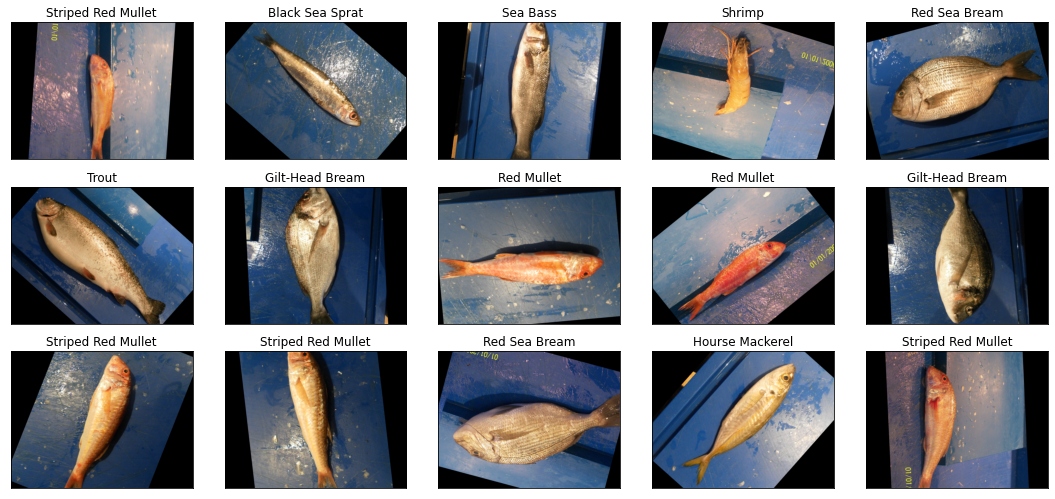

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(image_df, train_size = 0.9, shuffle=True, random_state=1)

In [7]:
train_df.shape

(8100, 2)

In [8]:
test_df.shape

(900, 2)

In [29]:
#since i use tranfer learning from MobileNetV2. it should be better to use mobilenetv2 preprocessing input function
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [34]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 7290 validated image filenames belonging to 9 classes.
Found 810 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [35]:
#use the technique of transfer learning from MobileNetV2 State of the art performance of mobile models on multiple tasks
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [36]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
        train_images,
        validation_data=val_images,
        epochs=20,
        callbacks=[
            #use early stopping to get the best weight and stop learning something useless
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=1,
                restore_best_weights=True
        )
    ]
)

Epoch 1/20
228/228 [==============================] - 134s 580ms/step - loss: 1.4322 - accuracy: 0.4686 - val_loss: 0.7589 - val_accuracy: 0.7198
Epoch 2/20
228/228 [==============================] - 130s 569ms/step - loss: 0.9149 - accuracy: 0.6587 - val_loss: 0.5157 - val_accuracy: 0.8235
Epoch 3/20
228/228 [==============================] - 133s 581ms/step - loss: 0.7494 - accuracy: 0.7254 - val_loss: 0.4808 - val_accuracy: 0.8049
Epoch 4/20
228/228 [==============================] - 133s 581ms/step - loss: 0.6508 - accuracy: 0.7667 - val_loss: 0.3604 - val_accuracy: 0.8691
Epoch 5/20
228/228 [==============================] - 133s 582ms/step - loss: 0.5770 - accuracy: 0.7840 - val_loss: 0.3151 - val_accuracy: 0.8852
Epoch 6/20
228/228 [==============================] - 134s 589ms/step - loss: 0.5303 - accuracy: 0.8040 - val_loss: 0.2907 - val_accuracy: 0.9000
Epoch 7/20
228/228 [==============================] - 135s 590ms/step - loss: 0.4888 - accuracy: 0.8189 - val_loss: 0.2515 -

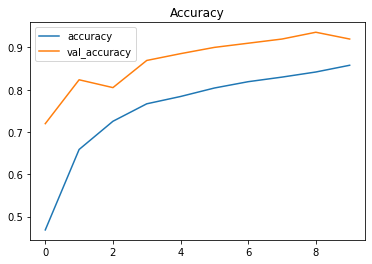

In [37]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

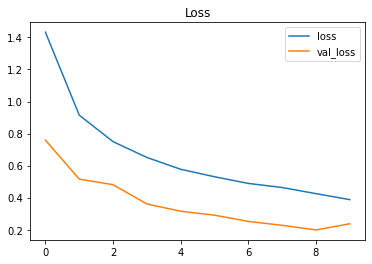

In [38]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [39]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.28421
Test Accuracy: 90.44%


In [40]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Black Sea Sprat', 'Striped Red Mullet', 'Black Sea Sprat', 'Red Sea Bream', 'Sea Bass']


In [41]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.71      0.97      0.82        95
   Gilt-Head Bream       0.92      0.96      0.94       103
   Hourse Mackerel       0.97      0.82      0.88       103
        Red Mullet       0.94      0.97      0.95        94
     Red Sea Bream       0.99      0.88      0.93        92
          Sea Bass       0.93      0.92      0.92        99
            Shrimp       0.90      0.95      0.93       107
Striped Red Mullet       0.93      0.72      0.81       116
             Trout       0.95      1.00      0.97        91

          accuracy                           0.90       900
         macro avg       0.91      0.91      0.91       900
      weighted avg       0.91      0.90      0.90       900



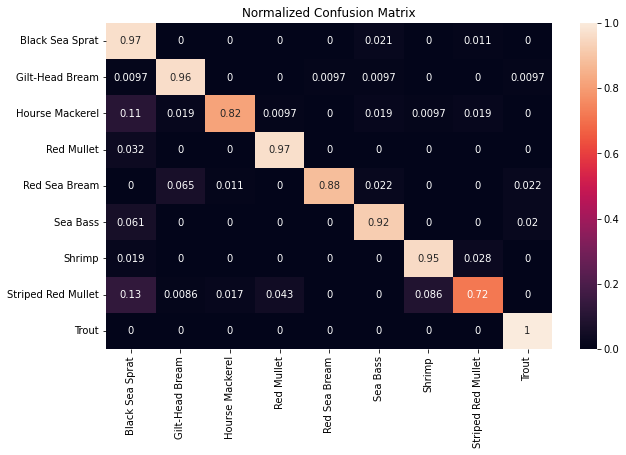

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

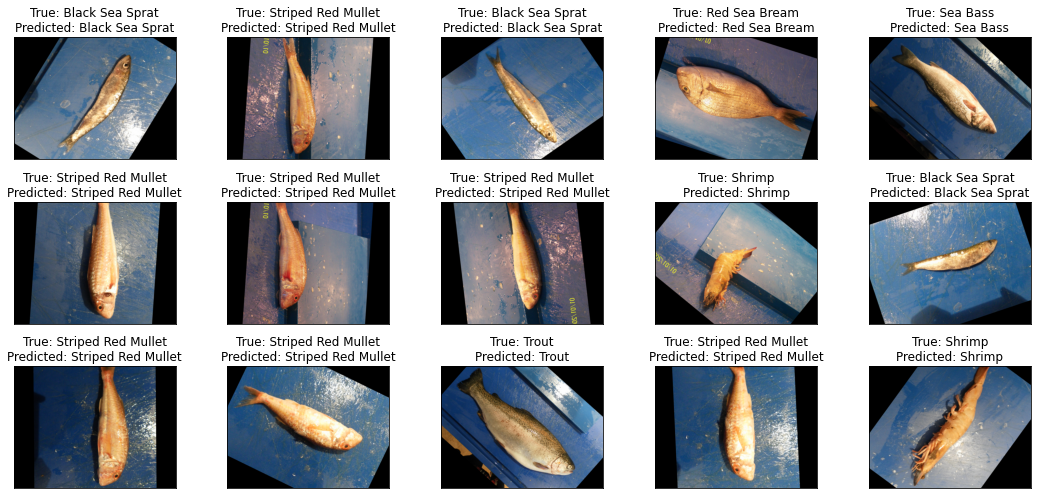

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()